#**FIRST_TEST**

#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define column names for the MONK's dataset
columns = ["class", "a1", "a2", "a3", "a4", "a5", "a6", "id"]

def load_monks_data(filename):
    # Read the file, handling irregular whitespace
    df = pd.read_csv(filename, sep=' ', skipinitialspace=True, names=columns)
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    X = df.drop(columns=['class'])
    y = df['class']
    return X, y

In [ ]:
def visualize_results(results_df, title):
    # Clean up column names for easier plotting
    plot_df = results_df.copy()
    plot_df['Hidden Layers'] = plot_df['param_hidden_layer_sizes'].astype(str)
    plot_df['Alpha'] = plot_df['param_alpha']
    plot_df['Solver'] = plot_df['param_solver']
    plot_df['Momentum'] = plot_df['param_momentum']
    plot_df['Accuracy'] = plot_df['mean_test_score']

    # 1. General Accuracy vs Alpha (Regularization)
    plt.figure(figsize=(12, 6))
    # We use 'Solver' as style to distinguish lines
    sns.lineplot(data=plot_df, x='Alpha', y='Accuracy', hue='Hidden Layers', style='Solver', markers=True, dashes=False)
    plt.xscale('log') # Log scale is best for regularization parameters
    plt.title(f'{title}: Accuracy vs Regularization (Alpha)')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.ylabel("Mean CV Accuracy")
    plt.show()

    # 2. Specific Plot for SGD Momentum
    # We filter for only results where solver is 'sgd'
    sgd_df = plot_df[plot_df['Solver'] == 'sgd']

    if not sgd_df.empty:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=sgd_df, x='Momentum', y='Accuracy', hue='Hidden Layers', marker='o')
        plt.title(f'{title}: Effect of Momentum (SGD Solver Only)')
        plt.xlabel("Momentum Value")
        plt.ylabel("Mean CV Accuracy")
        plt.grid(True, alpha=0.5)
        plt.show()

In [ ]:
# Load the datasets
# Ensure you have uploaded 'monks-1.train', 'monks-1.test', etc. to the Colab runtime
X_train_raw, y_train = load_monks_data('~/Documents/UniPi/1/UNIPI-Machine-Learning-Project/src/data/monk/monks-1.train')
X_test_raw, y_test = load_monks_data('~/Documents/UniPi/1/UNIPI-Machine-Learning-Project/src/data/monk/monks-1.test')
X_train_raw_2, y_train_2 = load_monks_data('~/Documents/UniPi/1/UNIPI-Machine-Learning-Project/src/data/monk/monks-2.train')
X_test_raw_2, y_test_2 = load_monks_data('~/Documents/UniPi/1/UNIPI-Machine-Learning-Project/src/data/monk/monks-2.test')

# Encoder setup
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform
X_train = encoder.fit_transform(X_train_raw)
X_test = encoder.transform(X_test_raw)
X_train_2 = encoder.fit_transform(X_train_raw_2)
X_test_2 = encoder.transform(X_test_raw_2)

print("Data loaded and encoded successfully.")

Data loaded and encoded successfully.


Starting MONK-1 Grid Search... (This might take a minute due to expanded grid)

Best Parameters found for MONK-1:
{'activation': 'tanh', 'alpha': 0, 'hidden_layer_sizes': (4, 4), 'learning_rate': 'adaptive', 'momentum': 0.5, 'solver': 'adam'}
Best Cross-Validation Accuracy: 74.83%
Test Set Accuracy: 100.00%


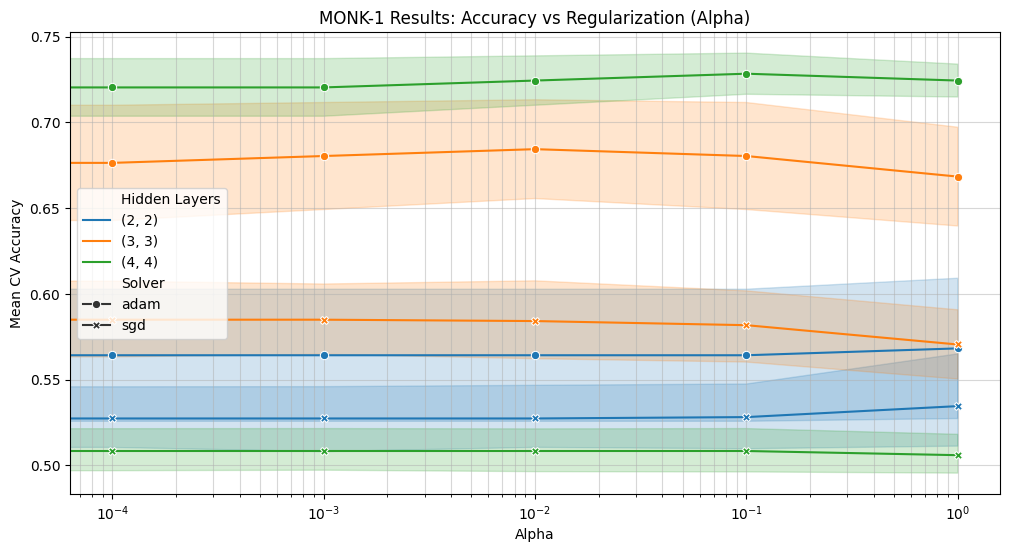

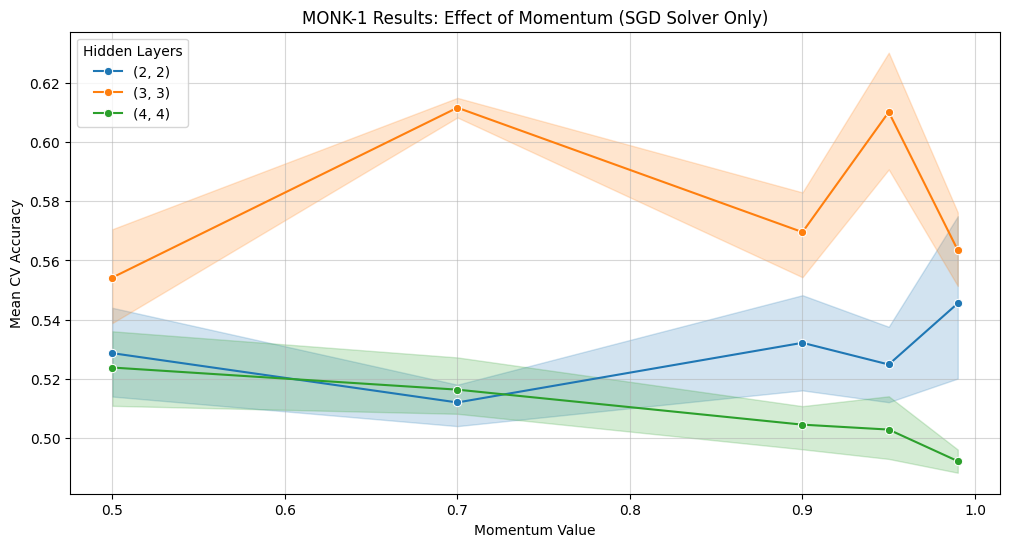

In [ ]:
# 1. Define the model (base settings)
# Increased max_iter because SGD often needs more iterations to converge than LBFGS
mlp = MLPClassifier(max_iter=5000, random_state=42)

# 2. Define the UPDATED grid of parameters
param_grid = {
    # Testing different architectures
    'hidden_layer_sizes': [(2, 2), (3, 3), (4, 4)],

    # Activation functions
    'activation': ['relu', 'tanh'],

    # Solvers: Added 'sgd' 'lbfgs',
    'solver': [ 'adam', 'sgd'],

    # Regularization: Expanded range (Logarithmic scale)
    'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1.0],

    # Momentum: Only affects 'sgd'.
    # Note: 'lbfgs' and 'adam' ignore this parameter, but GridSearchCV will still run the combinations.
    'momentum': [0.5, 0.7, 0.9, 0.95, 0.99],

    # Optional: Set learning rate to 'adaptive' to help SGD converge better
    'learning_rate': ['adaptive']
}

# 3. Initialize GridSearchCV
print("Starting MONK-1 Grid Search... (This might take a minute due to expanded grid)")
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("\nBest Parameters found for MONK-1:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2%}")

# Use the best model to predict on test set
best_model = grid_search.best_estimator_
test_acc = accuracy_score(y_test, best_model.predict(X_test))
print(f"Test Set Accuracy: {test_acc:.2%}")

# Visualize
visualize_results(pd.DataFrame(grid_search.cv_results_), "MONK-1 Results")

Training Adam model...
Training SGD model...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


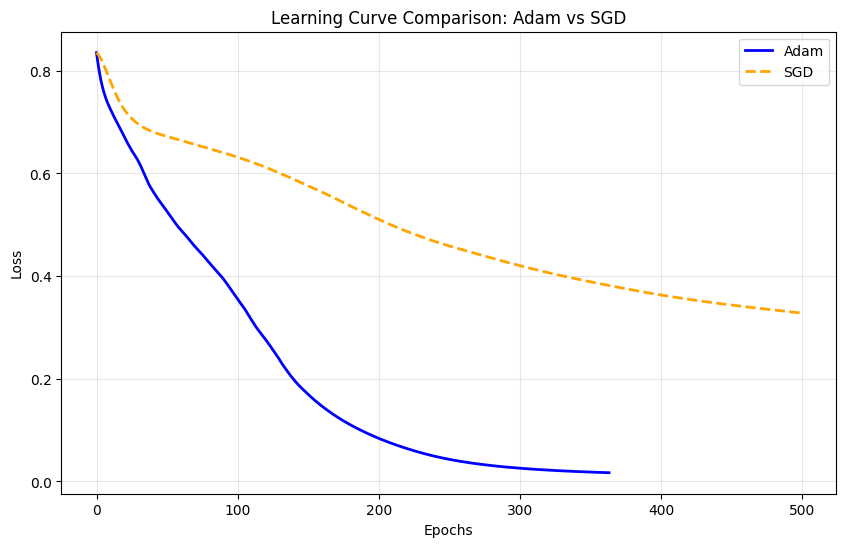

Final Adam Loss: 0.0170
Final SGD Loss:  0.3281


In [ ]:
# 1. Setup the common architecture (Use your best params here)
# Example params - replace with grid_search.best_params_ values if you have them
common_params = {
    'hidden_layer_sizes': (4,),  # Replace with your best size
    'activation': 'relu',        # Replace with your best activation
    'alpha': 0.01,               # Replace with your best alpha
    'max_iter': 500,
    'random_state': 42
}

# 2. Train Adam Model
print("Training Adam model...")
mlp_adam = MLPClassifier(solver='adam', learning_rate_init=0.01, **common_params)
mlp_adam.fit(X_train, y_train)

# 3. Train SGD Model
print("Training SGD model...")
# SGD often needs a higher learning rate or momentum to converge well
mlp_sgd = MLPClassifier(solver='sgd', learning_rate_init=0.01, momentum=0.9, **common_params)
mlp_sgd.fit(X_train, y_train)

# 4. Plot Comparison
plt.figure(figsize=(10, 6))

# Plot Adam
plt.plot(mlp_adam.loss_curve_, label='Adam', color='blue', linewidth=2)

# Plot SGD
plt.plot(mlp_sgd.loss_curve_, label='SGD', color='orange', linestyle='--', linewidth=2)

plt.title("Learning Curve Comparison: Adam vs SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Print final loss to see which converged better
print(f"Final Adam Loss: {mlp_adam.loss_curve_[-1]:.4f}")
print(f"Final SGD Loss:  {mlp_sgd.loss_curve_[-1]:.4f}")

In [ ]:
# Use the best model found to predict on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)

print(f"Test Set Accuracy with Best Params: {test_acc:.2%}")

# Optional: Verify performance on training set (should be near 100% for this problem)
train_acc = accuracy_score(y_train, best_model.predict(X_train))
print(f"Train Set Accuracy: {train_acc:.2%}")

Test Set Accuracy with Best Params: 100.00%
Train Set Accuracy: 100.00%


#**2ND_TEST**

Starting Grid Search... this may take a moment.

Best Parameters found:
{'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': (4, 4), 'learning_rate': 'adaptive', 'momentum': 0.5, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 100.00%


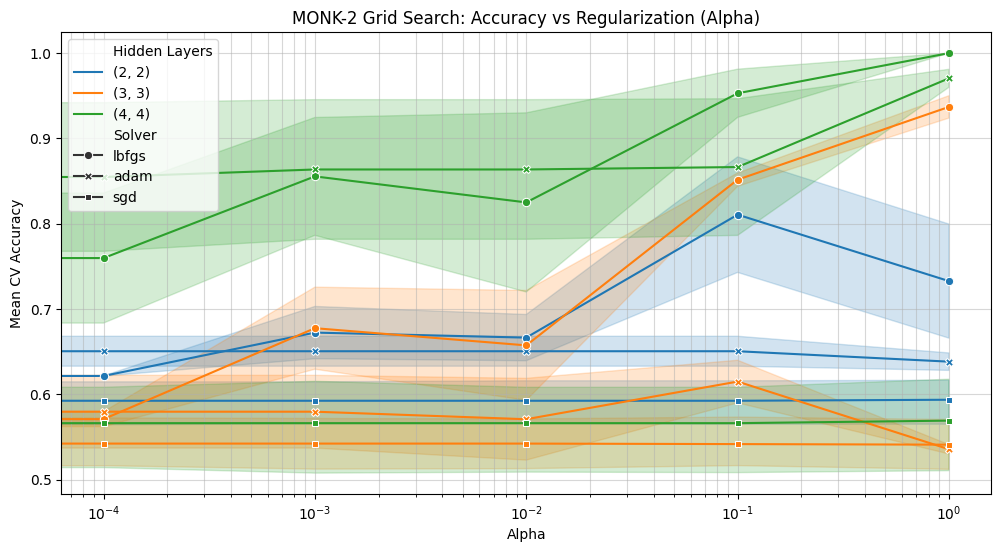

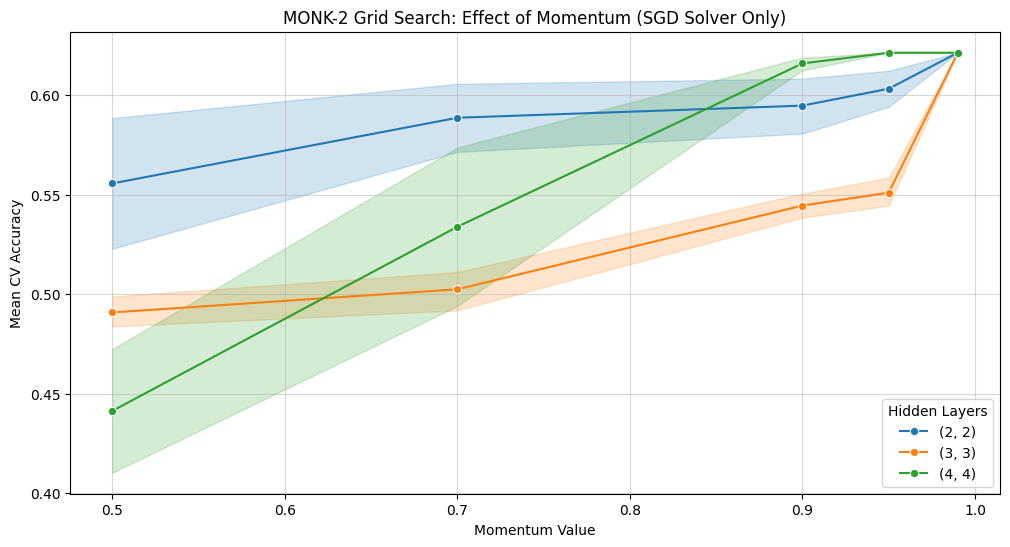

In [ ]:
# 3. Initialize GridSearchCV
# cv=5: uses 5-fold cross-validation
# n_jobs=-1: uses all available CPU cores
grid_search_2 = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

print("Starting Grid Search... this may take a moment.")
grid_search_2.fit(X_train_2, y_train_2)

print("\nBest Parameters found:")
print(grid_search_2.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search_2.best_score_:.2%}")

visualize_results(pd.DataFrame(grid_search_2.cv_results_), "MONK-2 Grid Search")

Training Adam model...
Training SGD model...


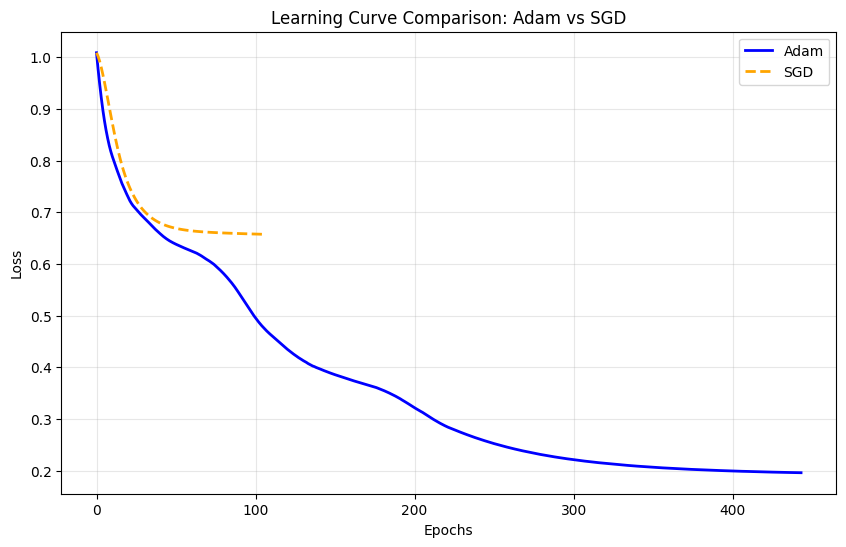

Final Adam Loss: 0.1957
Final SGD Loss:  0.6574


In [ ]:
# 1. Setup the common architecture (Use your best params here)
# Example params - replace with grid_search.best_params_ values if you have them
common_params = {
    'hidden_layer_sizes': (4,),  # Replace with your best size
    'activation': 'relu',        # Replace with your best activation
    'alpha': 0.01,               # Replace with your best alpha
    'max_iter': 500,
    'random_state': 42
}

# 2. Train Adam Model
print("Training Adam model...")
mlp_adam = MLPClassifier(solver='adam', learning_rate_init=0.01, **common_params)
mlp_adam.fit(X_train_2, y_train_2)

# 3. Train SGD Model
print("Training SGD model...")
# SGD often needs a higher learning rate or momentum to converge well
mlp_sgd = MLPClassifier(solver='sgd', learning_rate_init=0.01, momentum=0.9, **common_params)
mlp_sgd.fit(X_train_2, y_train_2)

# 4. Plot Comparison
plt.figure(figsize=(10, 6))

# Plot Adam
plt.plot(mlp_adam.loss_curve_, label='Adam', color='blue', linewidth=2)

# Plot SGD
plt.plot(mlp_sgd.loss_curve_, label='SGD', color='orange', linestyle='--', linewidth=2)

plt.title("Learning Curve Comparison: Adam vs SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Print final loss to see which converged better
print(f"Final Adam Loss: {mlp_adam.loss_curve_[-1]:.4f}")
print(f"Final SGD Loss:  {mlp_sgd.loss_curve_[-1]:.4f}")

In [ ]:
# Use the best model found to predict on the test set
best_model_2 = grid_search_2.best_estimator_
test_predictions_2 = best_model_2.predict(X_test_2)
test_acc = accuracy_score(y_test_2, test_predictions_2)

print(f"Test Set Accuracy with Best Params: {test_acc:.2%}")

# Optional: Verify performance on training set (should be near 100% for this problem)
train_acc = accuracy_score(y_train_2, best_model_2.predict(X_train_2))
print(f"Train Set Accuracy: {train_acc:.2%}")

Test Set Accuracy with Best Params: 100.00%
Train Set Accuracy: 100.00%


#**LAST_TEST**

In [ ]:
# [cite_start]Load the datasets [cite: 36, 1]
X_train_raw_3, y_train_3 = load_monks_data('~/Documents/UniPi/1/UNIPI-Machine-Learning-Project/src/data/monk/monks-3.train')
X_test_raw_3, y_test_3 = load_monks_data('~/Documents/UniPi/1/UNIPI-Machine-Learning-Project/src/data/monk/monks-3.test')

print(f"Loaded {len(X_train_raw_3)} training samples and {len(X_test_raw_3)} test samples.")

Loaded 122 training samples and 432 test samples.


In [ ]:
# Create the encoder
# sparse_output=False gives us a standard numpy array we can read easily
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data and transform both sets
X_train_3 = encoder.fit_transform(X_train_raw_3)
X_test_3 = encoder.transform(X_test_raw_3)

print(f"Feature shape after encoding: {X_train_3.shape}")

Feature shape after encoding: (122, 17)


In [ ]:
param_grid = {
    # Testing different architectures
    'hidden_layer_sizes': [(2, 2), (3, 3), (4, 4)],

    # Activation functions
    'activation': ['relu', 'tanh'],

    # Solvers: Added 'sgd'
    'solver': ['lbfgs', 'adam', 'sgd'],

    # Regularization: Expanded range (Logarithmic scale)
    'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1.0],

    # Momentum: Only affects 'sgd'.
    # Note: 'lbfgs' and 'adam' ignore this parameter, but GridSearchCV will still run the combinations.
    'momentum': [0.5, 0.7, 0.9, 0.95, 0.99],

    # Optional: Set learning rate to 'adaptive' to help SGD converge better
    'learning_rate': ['adaptive']
}

Starting Grid Search... this may take a moment.

Best Parameters found:
{'activation': 'relu', 'alpha': 0, 'hidden_layer_sizes': (3, 3), 'learning_rate': 'adaptive', 'momentum': 0.9, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 92.57%


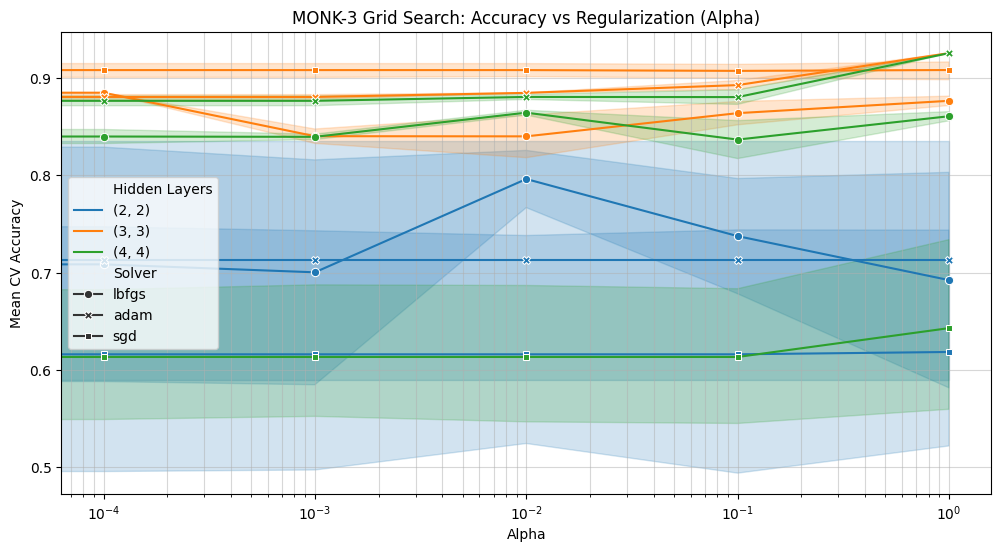

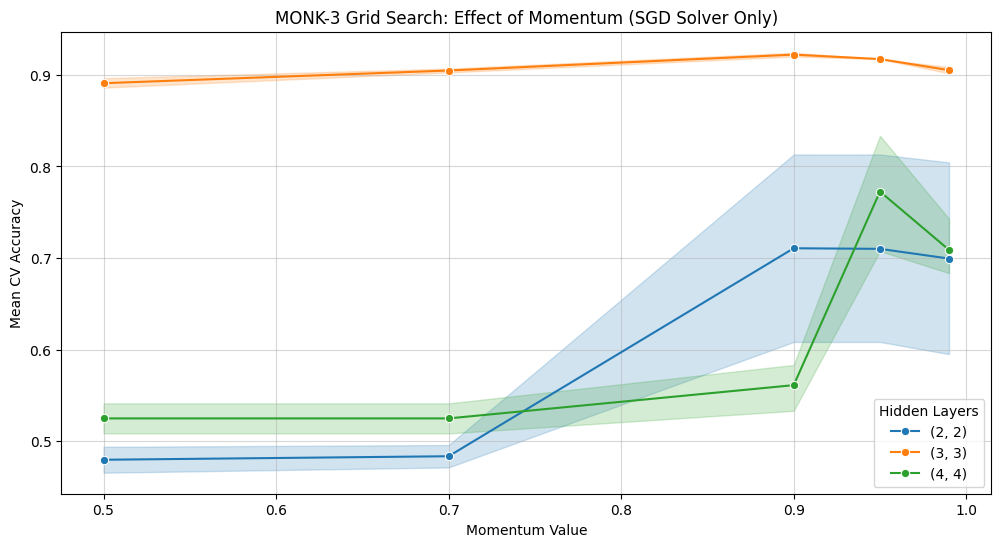

In [ ]:
# 3. Initialize GridSearchCV
# cv=5: uses 5-fold cross-validation
# n_jobs=-1: uses all available CPU cores
grid_search_3 = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

print("Starting Grid Search... this may take a moment.")
grid_search_3.fit(X_train_3, y_train_3)

print("\nBest Parameters found:")
print(grid_search_3.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search_3.best_score_:.2%}")

visualize_results(pd.DataFrame(grid_search_3.cv_results_), "MONK-3 Grid Search")

Training Adam model...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training SGD model...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


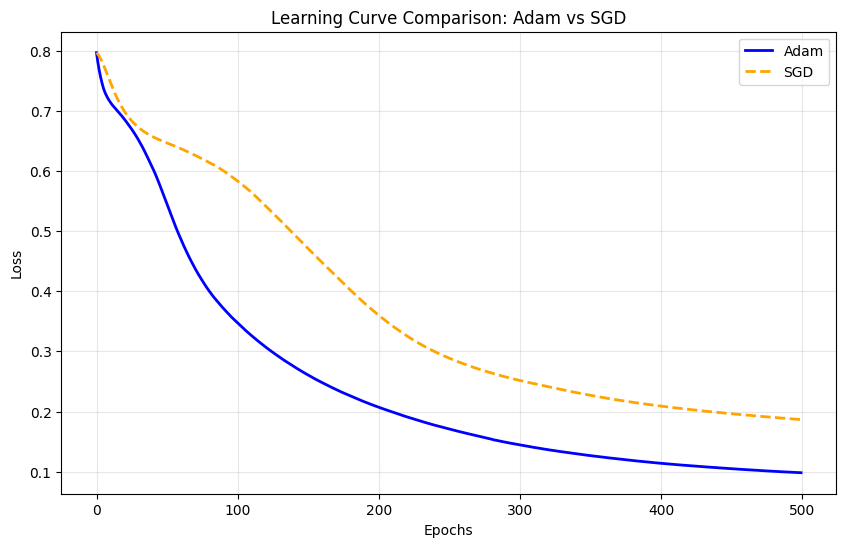

Final Adam Loss: 0.0982
Final SGD Loss:  0.1866


In [ ]:
# 1. Setup the common architecture (Use your best params here)
# Example params - replace with grid_search.best_params_ values if you have them
common_params = {
    'hidden_layer_sizes': (4,),  # Replace with your best size
    'activation': 'relu',        # Replace with your best activation
    'alpha': 0.01,               # Replace with your best alpha
    'max_iter': 500,
    'random_state': 42
}

# 2. Train Adam Model
print("Training Adam model...")
mlp_adam = MLPClassifier(solver='adam', learning_rate_init=0.01, **common_params)
mlp_adam.fit(X_train_3, y_train_3)

# 3. Train SGD Model
print("Training SGD model...")
# SGD often needs a higher learning rate or momentum to converge well
mlp_sgd = MLPClassifier(solver='sgd', learning_rate_init=0.01, momentum=0.9, **common_params)
mlp_sgd.fit(X_train_3, y_train_3)

# 4. Plot Comparison
plt.figure(figsize=(10, 6))

# Plot Adam
plt.plot(mlp_adam.loss_curve_, label='Adam', color='blue', linewidth=2)

# Plot SGD
plt.plot(mlp_sgd.loss_curve_, label='SGD', color='orange', linestyle='--', linewidth=2)

plt.title("Learning Curve Comparison: Adam vs SGD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Print final loss to see which converged better
print(f"Final Adam Loss: {mlp_adam.loss_curve_[-1]:.4f}")
print(f"Final SGD Loss:  {mlp_sgd.loss_curve_[-1]:.4f}")

In [ ]:
# Use the best model found to predict on the test set
best_model_3 = grid_search_3.best_estimator_
test_predictions_3 = best_model_3.predict(X_test_3)
test_acc = accuracy_score(y_test_3, test_predictions_3)

print(f"Test Set Accuracy with Best Params: {test_acc:.2%}")

# Optional: Verify performance on training set (should be near 100% for this problem)
train_acc = accuracy_score(y_train_3, best_model_3.predict(X_train_3))
print(f"Train Set Accuracy: {train_acc:.2%}")

Test Set Accuracy with Best Params: 97.22%
Train Set Accuracy: 93.44%
